In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Honda.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Accord,Seri_CRX,Seri_City,...,Model_2.2 EX,Model_2.2 VTi,Model_2.4 Executive,Model_3.5,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,875000,0.727273,-0.027778,-0.764423,-0.823970,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,649500,0.636364,0.000000,-1.163462,-1.063670,3.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,985000,0.818182,0.638889,0.177885,-1.127341,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,998000,0.727273,0.638889,0.177885,-1.078652,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,795000,0.545455,0.638889,0.177885,0.000000,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_11120\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,62631.007104,4.796125e+09,69254.058541,46928.99595


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 20:57:50,534] A new study created in memory with name: no-name-07132d9a-cc4a-46e3-a508-6033dd77752a
[I 2023-05-23 20:57:50,693] Trial 3 finished with value: 675110.4370178294 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.00020952995263102, 'max_depth': 12, 'min_child_weight': 254}. Best is trial 3 with value: 675110.4370178294.
[I 2023-05-23 20:57:50,696] Trial 7 finished with value: 674664.1047090048 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.00029394889532821314, 'max_depth': 9, 'min_child_weight': 286}. Best is trial 7 with value: 674664.1047090048.
[I 2023-05-23 20:57:50,721] Trial 0 finished with value: 555426.5779717923 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.020711757519306023, 'max_depth': 12, 'min_child_weight': 165}. Best is trial 0 with value: 555426.5779717923.
[I 2023-05-23 20:57:50,760] Trial 4 finished with value: 537850.5733393539 and parameters: {'c

[I 2023-05-23 20:57:51,911] Trial 31 finished with value: 241321.27445433382 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.10831178384479624, 'max_depth': 13, 'min_child_weight': 89}. Best is trial 19 with value: 72262.46415947161.
[I 2023-05-23 20:57:52,038] Trial 30 finished with value: 273200.4773033167 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.09439700533139574, 'max_depth': 13, 'min_child_weight': 40}. Best is trial 19 with value: 72262.46415947161.
[I 2023-05-23 20:57:52,119] Trial 33 finished with value: 363488.3228347938 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.06427272407922176, 'max_depth': 13, 'min_child_weight': 40}. Best is trial 19 with value: 72262.46415947161.
[I 2023-05-23 20:57:52,150] Trial 32 finished with value: 408266.01667967654 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.05236686834089694, 'max_depth': 13, 'min_child_weig

[I 2023-05-23 20:57:53,918] Trial 57 finished with value: 75839.51623327844 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.3050654566719648, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 19 with value: 72262.46415947161.
[I 2023-05-23 20:57:54,323] Trial 61 finished with value: 116020.4517133382 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.2986636409499365, 'max_depth': 8, 'min_child_weight': 224}. Best is trial 19 with value: 72262.46415947161.
[I 2023-05-23 20:57:54,359] Trial 62 finished with value: 98807.58946819097 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.2677980801598221, 'max_depth': 12, 'min_child_weight': 28}. Best is trial 19 with value: 72262.46415947161.
[I 2023-05-23 20:57:54,384] Trial 63 finished with value: 96938.94863585128 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.29712110976079775, 'max_depth': 12, 'min_child_weight': 2

[I 2023-05-23 20:57:55,972] Trial 90 finished with value: 113987.08316722172 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.22698539655965289, 'max_depth': 14, 'min_child_weight': 22}. Best is trial 19 with value: 72262.46415947161.
[I 2023-05-23 20:57:56,000] Trial 91 finished with value: 115523.64246510612 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.22575257620713474, 'max_depth': 14, 'min_child_weight': 24}. Best is trial 19 with value: 72262.46415947161.
[I 2023-05-23 20:57:56,036] Trial 95 finished with value: 113300.78236478071 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.21996924084991734, 'max_depth': 14, 'min_child_weight': 23}. Best is trial 19 with value: 72262.46415947161.
[I 2023-05-23 20:57:56,039] Trial 94 finished with value: 114245.09285975965 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.2169119143809269, 'max_depth': 14, 'min_child_wei

[I 2023-05-23 20:57:57,620] Trial 120 finished with value: 96849.73045695544 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.27451458978120474, 'max_depth': 15, 'min_child_weight': 7}. Best is trial 104 with value: 69447.73808671147.
[I 2023-05-23 20:57:57,727] Trial 121 finished with value: 69727.61410939749 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.325558871217601, 'max_depth': 15, 'min_child_weight': 1}. Best is trial 104 with value: 69447.73808671147.
[I 2023-05-23 20:57:57,740] Trial 124 finished with value: 140058.7396670273 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.2610438168497843, 'max_depth': 4, 'min_child_weight': 247}. Best is trial 104 with value: 69447.73808671147.
[I 2023-05-23 20:57:57,794] Trial 122 finished with value: 125541.14027977169 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.2759664503513975, 'max_depth': 13, 'min_child_weig

[I 2023-05-23 20:57:59,589] Trial 148 finished with value: 91792.694194265 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.36115759154489085, 'max_depth': 14, 'min_child_weight': 8}. Best is trial 137 with value: 65350.017950309186.
[I 2023-05-23 20:57:59,630] Trial 150 finished with value: 93399.51409193431 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.3725458371006068, 'max_depth': 4, 'min_child_weight': 12}. Best is trial 137 with value: 65350.017950309186.
[I 2023-05-23 20:57:59,669] Trial 152 finished with value: 91482.54737552717 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.36722126167511, 'max_depth': 3, 'min_child_weight': 9}. Best is trial 137 with value: 65350.017950309186.
[I 2023-05-23 20:57:59,702] Trial 153 finished with value: 90046.84987775645 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.3788260110408652, 'max_depth': 4, 'min_child_weight':

[I 2023-05-23 20:58:01,559] Trial 180 finished with value: 70178.86944503625 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.30586737370620937, 'max_depth': 13, 'min_child_weight': 1}. Best is trial 137 with value: 65350.017950309186.
[I 2023-05-23 20:58:01,748] Trial 182 finished with value: 626445.6836534151 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.008018711680173924, 'max_depth': 11, 'min_child_weight': 1}. Best is trial 137 with value: 65350.017950309186.
[I 2023-05-23 20:58:01,764] Trial 183 finished with value: 98826.37354567478 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.30717025016954574, 'max_depth': 8, 'min_child_weight': 22}. Best is trial 137 with value: 65350.017950309186.
[I 2023-05-23 20:58:01,802] Trial 181 finished with value: 69727.93566702922 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.3023865313065314, 'max_depth': 13, 'min_child

[I 2023-05-23 20:58:03,611] Trial 211 finished with value: 91083.46035264125 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.492608994063811, 'max_depth': 11, 'min_child_weight': 11}. Best is trial 137 with value: 65350.017950309186.
[I 2023-05-23 20:58:03,612] Trial 210 finished with value: 95742.81916442618 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.4939531339285347, 'max_depth': 11, 'min_child_weight': 10}. Best is trial 137 with value: 65350.017950309186.
[I 2023-05-23 20:58:03,727] Trial 212 finished with value: 91979.7177676201 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.39187232663618055, 'max_depth': 14, 'min_child_weight': 11}. Best is trial 137 with value: 65350.017950309186.
[I 2023-05-23 20:58:03,827] Trial 213 finished with value: 67704.52218686411 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.49155431388825493, 'max_depth': 14, 'min_child_

[I 2023-05-23 20:58:06,185] Trial 239 finished with value: 68932.85532884434 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.4991922465783703, 'max_depth': 12, 'min_child_weight': 1}. Best is trial 137 with value: 65350.017950309186.
[I 2023-05-23 20:58:06,250] Trial 243 finished with value: 67308.59465397171 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.35413473033570814, 'max_depth': 13, 'min_child_weight': 1}. Best is trial 137 with value: 65350.017950309186.
[I 2023-05-23 20:58:06,315] Trial 241 finished with value: 566180.2650145809 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01851600234285408, 'max_depth': 13, 'min_child_weight': 8}. Best is trial 137 with value: 65350.017950309186.
[I 2023-05-23 20:58:06,346] Trial 242 finished with value: 67491.0953104384 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.4819808038549848, 'max_depth': 13, 'min_child_we

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 65350.0180
Best params:
	colsample_bytree: 0.8
	subsample: 0.8
	learning_rate: 0.4999387504933799
	max_depth: 9
	min_child_weight: 1


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.4],
                  "max_depth": [9,13],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.8],
               'subsample': [0.8],
               'min_child_weight': [1]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 13, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.8}
{'TestDeger': 60737.15744124677, 'MSE': 4214811043.0350127, 'RMSE': 64921.57609789686, 'MAE': 44860.33997515291}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9478477121951272

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.9445699846096254

In [17]:
marka_model = joblib.dump(grid_final_model, "Honda.pkl")

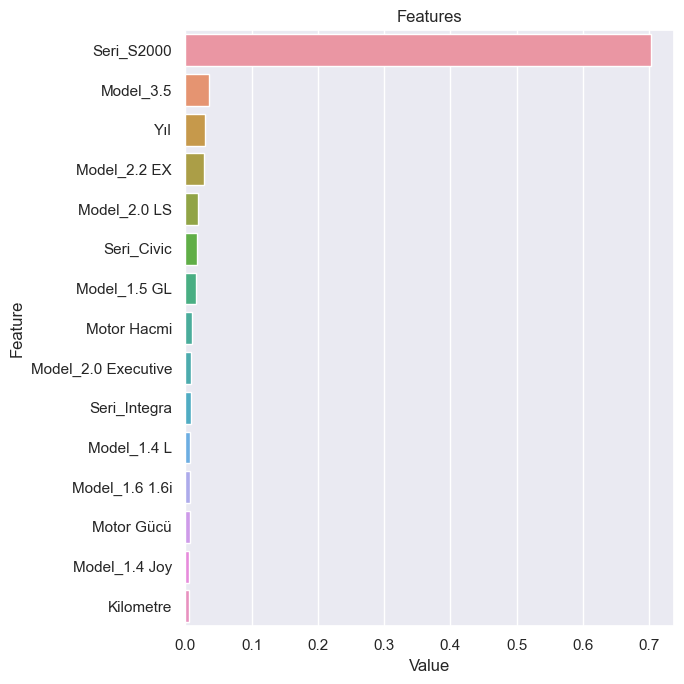

In [16]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)